# Статистика, DS-поток
## Практическое задание 1


**Правила:**

* Дедлайн **13 сентября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  10 баллов
* Задача 2 -  5 баллов
* Задача 3 -  5 баллов

**Важность задач:**

* *средне-высокая:* задачи 1, 2, 3;

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

---
## Задача 1.

Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функции. Реализация должна уметь вычислять интеграл вида:
$$ \int\limits_{l_1}^{h_1} ... \int\limits_{l_d}^{h_d} f(x_1, ... , x_d) dx_1 ... dx_d $$

*Детали реализации*: на вход функции подаются векторы $l = (l_1, ... , l_d)$ и $h = (h_1, ... ,h_d)$, число $n$ -- максимальное допустимое число вызовов функции $f$ (если вы не делаете лишних вызовов, оно равно числу точек-центров отрезков, прямоугольников, параллелипипедов, и т.д. в многомерных случаях). Использование циклов, кроме циклов по числу интегралов $d$, **наказуемо**.

Для быстрой работы метода прямоугольников мы будем использовать функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. Как всегда, настоятельно советуем читать документацию.

In [33]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]

# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1

# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [28]:
class Integrator:
    
    @staticmethod
    def integrate(f, low, high, n, method="rectangle"):
        """
        Вычисление определенного интеграла.
        
        Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
        n --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").
                            
        Возвращает приближенное значение интеграла.
        """
        
        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        n = int(n)

        return Integrator.methods[method](f, low, high, n)
    
    
    def integrate_monte_carlo(f, low, high, n):
        """Метод монте-карло"""
        
        dim = len(high)
        dots = sps.uniform(loc=low, scale=(np.array(high)-np.array(low))).rvs(size=(n, dim)) 
        # случайные точки, в которых будем вычислять функцию
        
        diff = high - low # длины отрезков разбиения
        
        # вычисление интеграла
        answer = np.mean(f(dots))
        for i in range(dim):
            answer *= diff[i]
            
        return answer
    
    
    def integrate_rectangle(f, low, high, n):
        """Метод прямоугольников"""
        
        dim = len(high)
        
        n_rounded = int(np.round(n**(1/dim))) # количество точек, в которых вычисляем функцию
        
        diff = high - low # длины отрезов разбиения
        
        centers_of_ranges = np.zeros((dim, n_rounded))
        
        # для каждой размерности найдите центры отрезков разбиения
        for i in range(dim):
            centers_of_ranges[i] = np.linspace(low[i] + diff[i] / n_rounded, high[i] - diff[i] / n_rounded,
                                               n_rounded)
        
        centers = np.meshgrid(*centers_of_ranges)
        f_vals = f(np.stack(centers).reshape(dim, -1).T)
        return f_vals.sum() * np.prod(diff) / n
    
    
    methods = {
        "rectangle": integrate_rectangle,
        "monte_carlo": integrate_monte_carlo
    }

Вычислите $\int\limits_0^1 \int\limits_3^4 \left(x^2 + y^2\right) dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов? Объясните результаты с точки зрения теории.

In [29]:
square_sum = lambda x: np.sum(x**2, axis=1)

In [31]:
low = [3, 0]
high = [4, 1]
n = 1e6
start_time = datetime.now()
rectangle_res = Integrator.integrate(square_sum, low, high, n, method='rectangle')
print('Результат с методом прямоугольников:', rectangle_res)
print('Время работы:', datetime.now() - start_time)
print()

start_time = datetime.now()
monte_carlo_res = Integrator.integrate(square_sum, low, high, n=1e6, method='monte_carlo')
print('Результат с методом Монте Карло:', monte_carlo_res)
print('Время работы:', datetime.now() - start_time)
print()

print('Истинное значение интеграла:', '12.(6)')

Результат с методом прямоугольников: 12.666333000333667
Время работы: 0:00:00.017464

Результат с методом Монте Карло: 12.66891356610684
Время работы: 0:00:00.041653

Истинное значение интеграла: 12.(6)


**Вывод:** Видно, что метод прямоугольников в данном случае сработал точнее, чем метод Монте Карло, так как показал более точный результат. Это скорее всего связано с тем, что у нас малая кратность. Также метод прямоугольников сработал быстрее метода Монте Карло почти в 2.4 раза. Это может быть связано с тем, что в методе Монте Карло мы генерируем очень большую выборку случайных величин, в отличии от метода прямоугольников. В итоге метод прямоугольников отработал лучше во всех планах (с точки зрения и точности, и времени).

---
## Задача 2.

Для $d = 1...8$ оцените скорость сходимости методов для интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i$$

Т.е. $\int\limits_0^1 x_1^2 dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right) dx_1 dx_2$ и так далее.

Вычислите точное значение этого интеграла и для каждого $d$ постройте график зависимости вычисленного значения интеграла от числа $n$ вызовов подынтегральной функции (в корректном решении равно числу точек-центров), которое разрешено использовать для каждого метода вычисления интеграла. Рекомендуется рассмотреть значения $n$ вплоть до $d \times 1000$.

Для вашего удобства, мы написали функцию, которая строит графики в этой задаче.

In [26]:
max_dim = 8


def plot_convergence(f, low, high, n_list, theoretical_value, max_dim):
    """
    Построение графиков сходимости методов Монте-Карло и прямоугольников.
    
    Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
    n_list --- список.
    theoretical_value --- точное значение интеграла.
    max_dim --- максимальная кратность интеграла.
    """
    
    source = np.arange(max_dim) + 1
    i = Integrator()
    
    for d in source:
        rectangles_computed = np.zeros(len(n_list))
        monte_carlo_computed = np.zeros(len(n_list))
        
        for n in np.arange(len(n_list)):
            mn = i.integrate(f, low[:d], high[:d], n_list[n],
                             method="monte_carlo")
            rc = i.integrate(f, low[:d], high[:d], n_list[n])
            monte_carlo_computed[n] = mn
            rectangles_computed[n] = rc
        
        plt.figure(figsize=(15, 5))
        plt.title('Зависимость вычисленного значения интеграла' +
                  ' от n для d = {}'.format(d), fontsize=14)      
        plt.xlabel("Число вызовов функции", fontsize=14)
        plt.ylabel("Значение интеграла", fontsize=14)
        plt.plot(n_list, monte_carlo_computed, color='blue',
                 label="по методу Монте-Карло")
        plt.plot(n_list, rectangles_computed, color='magenta',
                 label="по методу прямоугольников")
        plt.axhline(y=theoretical_value[d - 1], color='indigo',
                    linestyle='--', label="истинное значение")
        plt.legend(fontsize=14)

/var/folders/bb/qdgrx7h55vn6q52p2j93xjjc0000gn/T/ipykernel_9221/907876327.py:60: RuntimeWarning: divide by zero encountered in long_scalars
  centers_of_ranges[i] = np.linspace(low[i] + diff[i] / n_rounded, high[i] - diff[i] / n_rounded,
/var/folders/bb/qdgrx7h55vn6q52p2j93xjjc0000gn/T/ipykernel_9221/907876327.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return f_vals.sum() * np.prod(diff) / n


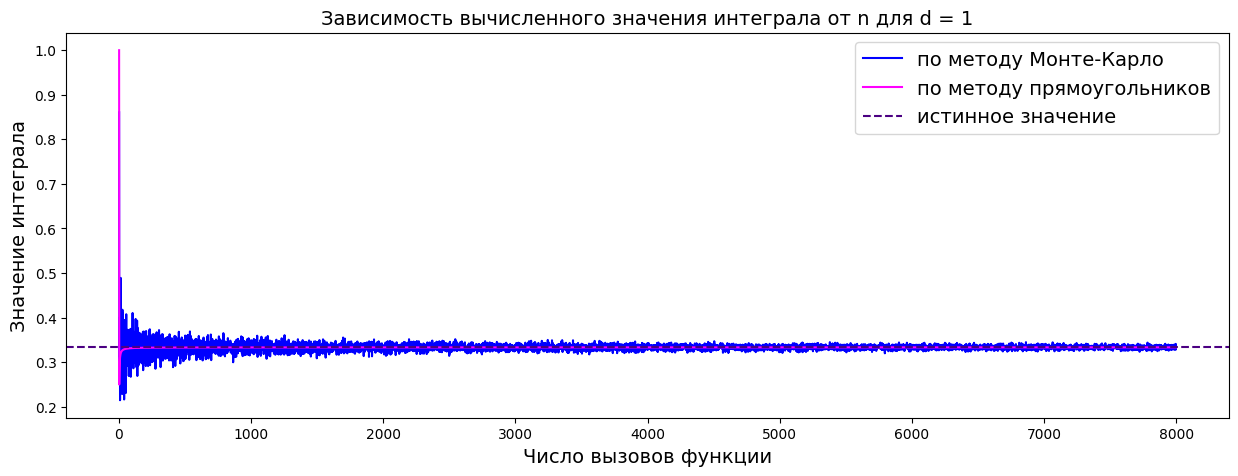

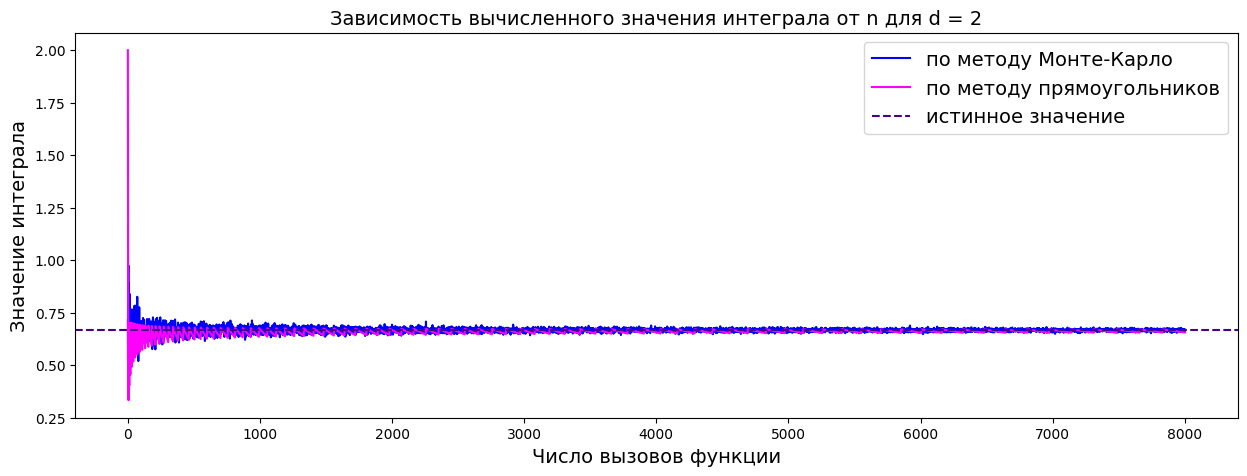

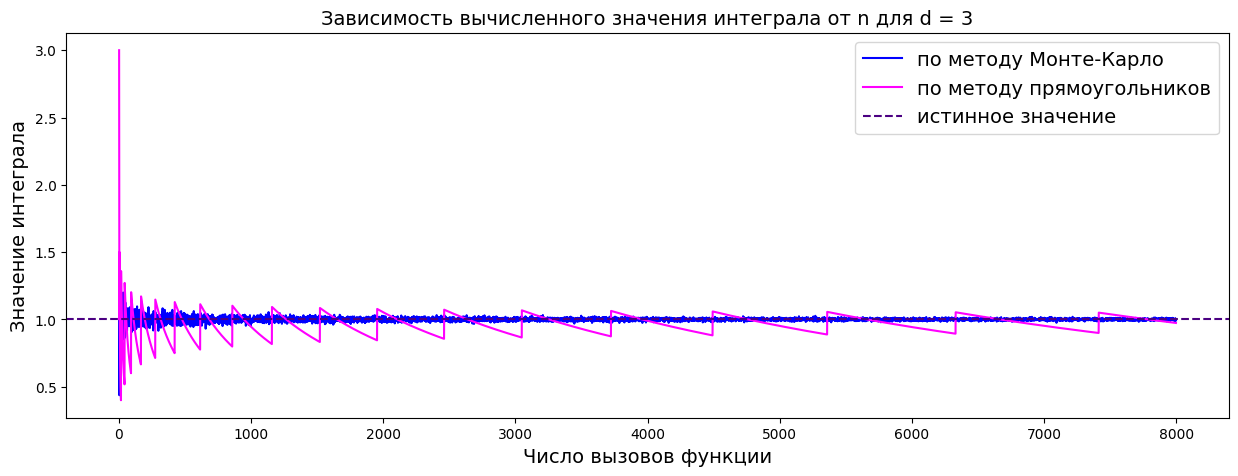

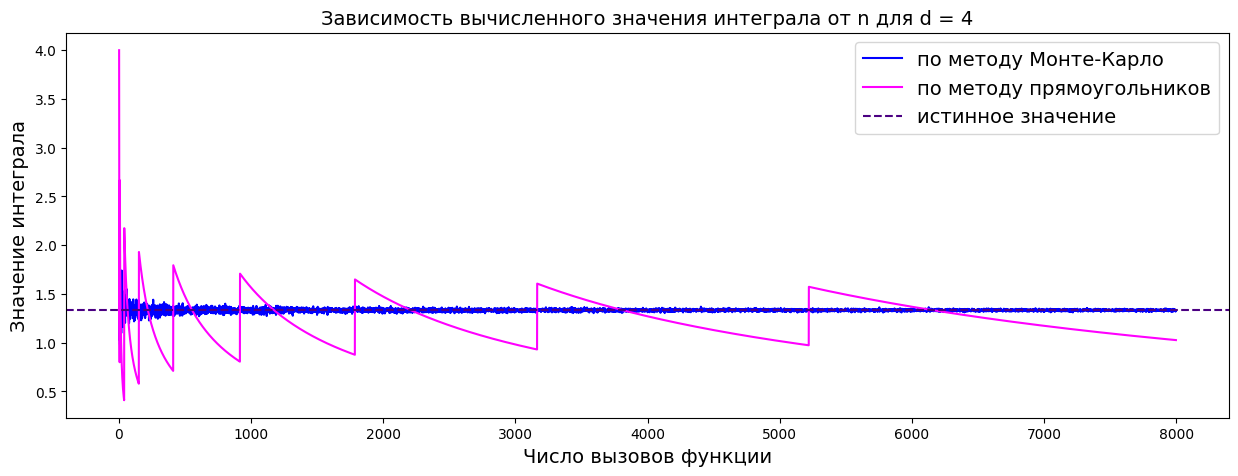

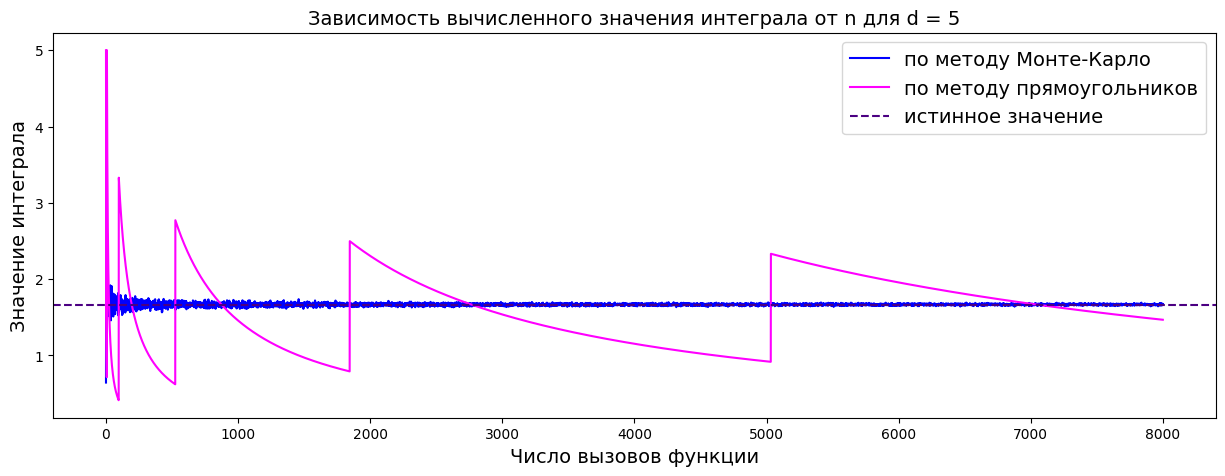

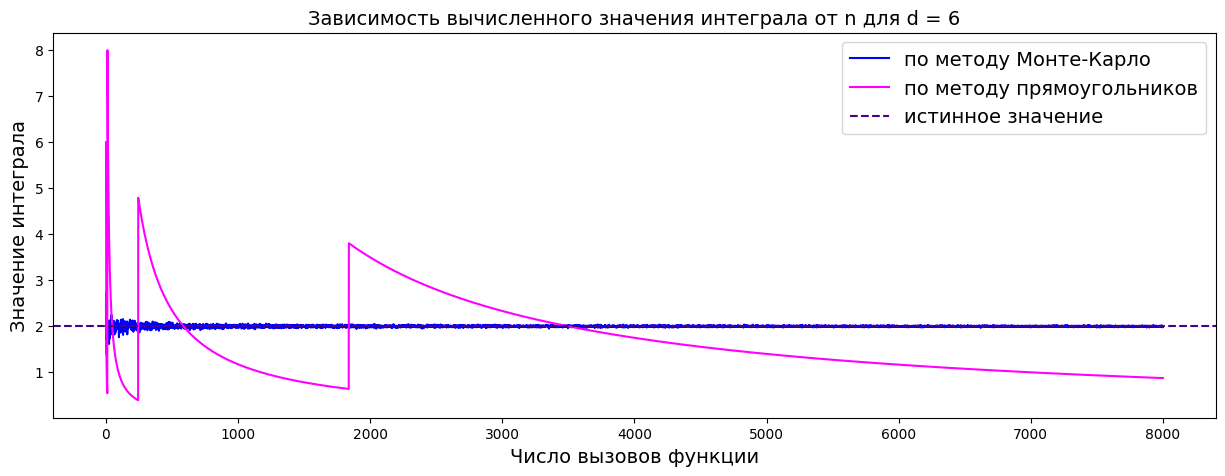

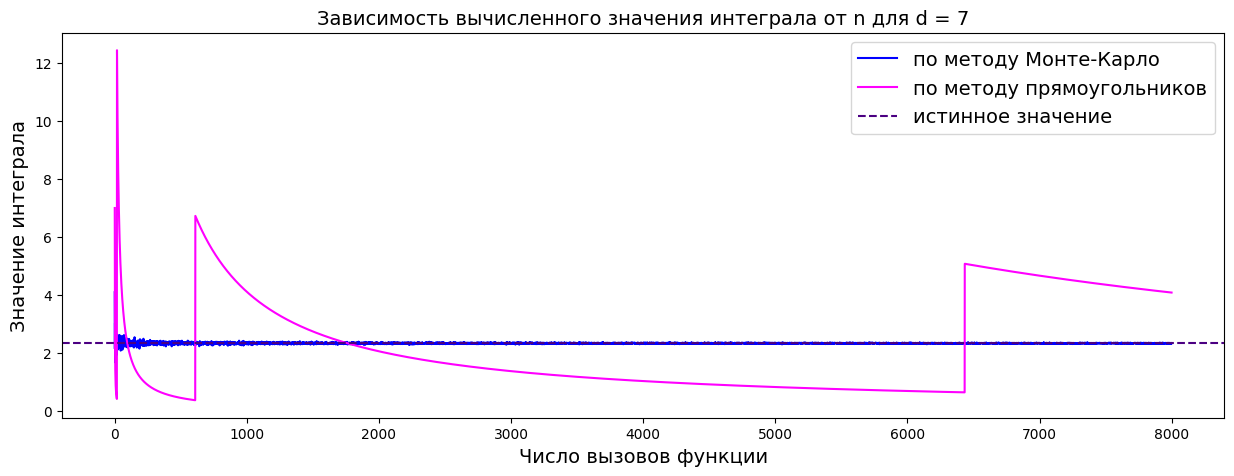

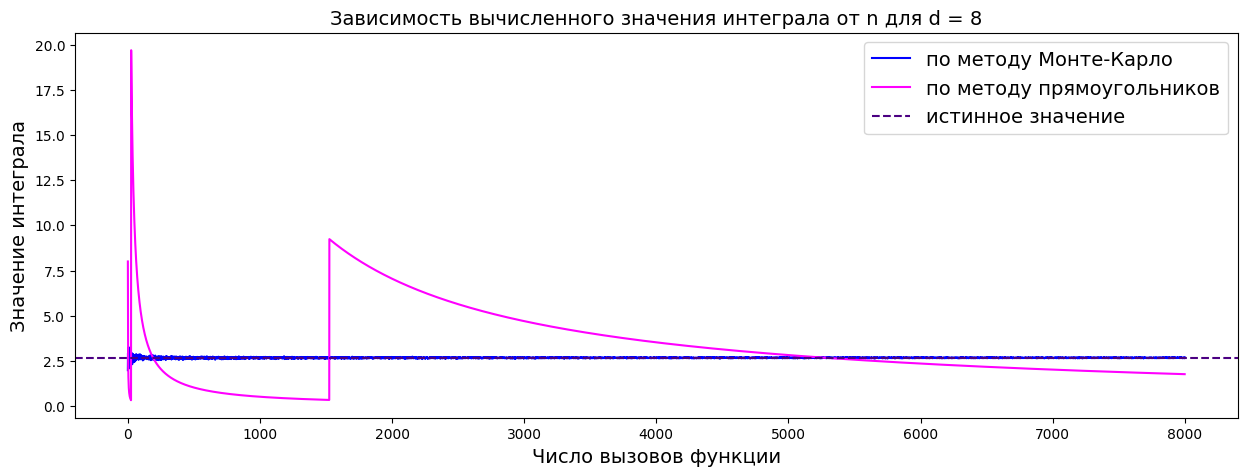

In [27]:
low = np.array([0] * max_dim)
high = np.array([1] * max_dim)
n_list = np.arange(max_dim * 1000)
theoretical_value = [0.3333, 0.66667, 1, 1.3333, 1.66667, 2, 2.3333, 2.66667]
plot_convergence(square_sum, low, high, n_list, theoretical_value, max_dim)

Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод.

С чем связано такое поведение графиков?

Сравните результаты с предыдущей задачей.

**Вывод:** При малых размерностях (d = 1 и d = 2) метод прямоугольников сходится быстрее. При больших значениях d метод Монте Карло сходится быстрее, а метод прямоугольников вовсе не сходится. Поэтому при малых размерностях выгоднее использовать метод прямоугольников, а при больших - метод Монте Карло. При малых d можно убедиться в том, что погрешность метода Монте Карло $\frac{1} {\sqrt(n)}$ больше, чем метода прямоугольников $\frac{1} {n^2}$.

---
## Задача 3.

Вам предлагается численно посчитать многомерный интеграл Пуассона для размерности $d=5$ и некоторой симметричной положительно определенной матрицы $A$, которую вы выберете сами. Зависит ли интеграл от выбора $A$? 
$$\int\limits_{\mathbb{R}^d} exp( - x^T A x) dx $$

Сравните результаты двух методов с истинным значением интеграла. Как вы думаете, какой метод выдает более точный результат? Количество итераций каждого метода должно быть не менее $10^6$. Теоретическое вычисление интеграла можно не приводить, достаточно написать ответ.

**Комментарий:** В этой задаче особенно важно выбрать правильные пределы интегрирования. 
Например, для единичной матрицы достаточно взять интеграл с пределами внутри области $[-5, 5]^5$

В связи с этим просим Вас ответить на наводящие вопросы. 
1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло? 
2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?

В этой задаче нельзя использовать циклы. Для вычисления функции в точках используете простые векторно-матричные операции в `numpy`.

In [ ]:
<...>

Рассмотрим отношение интегралов: 
$$
F(t) = \frac{ \int\limits_{-\infty}^{t_1} ... \int\limits_{-\infty}^{t_k} exp \left( - \frac12 x^T A x \right) dx}{ \int\limits_{\mathbb{R}^n} exp \left( - \frac12 x^T A x \right) dx}.
$$
В чем его вероятностный смысл?